# Improved Player Points Prediction Model

This notebook implements an improved model for predicting NBA player points.
Improvements include:
1.  **Feature Engineering**:
    *   Rolling averages (3, 5, 10, season).
    *   Lag features.
    *   Home/Away indicator.
    *   Rest days.
    *   Opponent defensive stats.
2.  **Model**: XGBoost Regressor.
3.  **Evaluation**: Time-series split validation.

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
import sys
import os

# Add src to path to import data loader if needed, though we can load csv directly
sys.path.append(os.path.abspath(os.path.join('..', '..')))

In [2]:
# Load Data
player_df = pd.read_csv('../../data/raw/nba_player_gamelogs_2024_25.csv')
team_df = pd.read_csv('../../data/raw/nba_team_gamelogs_2024_25.csv')

# Convert dates
player_df['GAME_DATE'] = pd.to_datetime(player_df['GAME_DATE'])
team_df['GAME_DATE'] = pd.to_datetime(team_df['GAME_DATE'])

# Sort
player_df = player_df.sort_values(['PLAYER_ID', 'GAME_DATE'])
team_df = team_df.sort_values(['TEAM_ID', 'GAME_DATE'])

print(f"Player logs shape: {player_df.shape}")
print(f"Team logs shape: {team_df.shape}")

Player logs shape: (26306, 32)
Team logs shape: (2460, 29)


In [3]:
# Feature Engineering: Basic

# Home/Away
player_df['IS_HOME'] = player_df['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# Rest Days
player_df['REST_DAYS'] = player_df.groupby('PLAYER_ID')['GAME_DATE'].diff().dt.days
player_df['REST_DAYS'] = player_df['REST_DAYS'].fillna(3) # Assume 3 days rest for first game or missing

# Opponent Abbreviation
def get_opponent(matchup):
    if 'vs.' in matchup:
        return matchup.split(' vs. ')[1]
    else:
        return matchup.split(' @ ')[1]

player_df['OPPONENT_ABBREVIATION'] = player_df['MATCHUP'].apply(get_opponent)

In [4]:
# Feature Engineering: Advanced Stats (TS%, USG%, eFG%)

# Calculate TS%
# Formula: PTS / (2 * (FGA + 0.44 * FTA))
player_df['TS_PCT'] = player_df['PTS'] / (2 * (player_df['FGA'] + 0.44 * player_df['FTA']))
player_df['TS_PCT'] = player_df['TS_PCT'].fillna(0)

# Calculate eFG%
# Formula: (FGM + 0.5 * FG3M) / FGA
player_df['eFG_PCT'] = (player_df['FGM'] + 0.5 * player_df['FG3M']) / player_df['FGA']
player_df['eFG_PCT'] = player_df['eFG_PCT'].fillna(0)

# Calculate USG%
# Formula: 100 * ((FGA + 0.44 * FTA + TOV) * (TmMP / 5)) / (MP * (TmFGA + 0.44 * TmFTA + TmTOV))

# We need team stats for each game
team_stats_cols = ['GAME_ID', 'TEAM_ID', 'FGA', 'FTA', 'TOV', 'MIN']
team_stats_for_merge = team_df[team_stats_cols].rename(columns={
    'FGA': 'TM_FGA',
    'FTA': 'TM_FTA',
    'TOV': 'TM_TOV',
    'MIN': 'TM_MIN'
})

player_df = pd.merge(player_df, team_stats_for_merge, on=['GAME_ID', 'TEAM_ID'], how='left')

player_df['USG_PCT'] = 100 * ((player_df['FGA'] + 0.44 * player_df['FTA'] + player_df['TOV']) * (player_df['TM_MIN'] / 5)) / \
                       (player_df['MIN'] * (player_df['TM_FGA'] + 0.44 * player_df['TM_FTA'] + player_df['TM_TOV']))
player_df['USG_PCT'] = player_df['USG_PCT'].fillna(0).replace([np.inf, -np.inf], 0)

In [12]:
# Feature Engineering: Fatigue

# 1. Back-to-Back
player_df['IS_BACK_TO_BACK'] = player_df['REST_DAYS'].apply(lambda x: 1 if x == 1 else 0)

# 2. Games/Minutes in last 7 days
# Ensure GAME_DATE is datetime
player_df['GAME_DATE'] = pd.to_datetime(player_df['GAME_DATE'])

# Set index for time-based rolling
# We use a temporary dataframe or modify in place. Modifying in place requires reset_index later.
player_df = player_df.set_index('GAME_DATE')

# Calculate rolling stats
# closed='left' excludes the current record, preventing data leakage
# We group by PLAYER_ID so the rolling window is specific to each player
player_df['GAMES_IN_LAST_7_DAYS'] = player_df.groupby('PLAYER_ID')['GAME_ID'].transform(lambda x: x.rolling('7D', closed='left').count())
player_df['MIN_IN_LAST_7_DAYS'] = player_df.groupby('PLAYER_ID')['MIN'].transform(lambda x: x.rolling('7D', closed='left').sum())

# Reset index to get GAME_DATE back as column
player_df = player_df.reset_index()

# Fill NaNs (start of season or no games in window)
player_df['GAMES_IN_LAST_7_DAYS'] = player_df['GAMES_IN_LAST_7_DAYS'].fillna(0)
player_df['MIN_IN_LAST_7_DAYS'] = player_df['MIN_IN_LAST_7_DAYS'].fillna(0)

### New Features Added
- **TS% (True Shooting Percentage)**: A measure of shooting efficiency that takes into account field goals, 3-point field goals, and free throws.
- **USG% (Usage Percentage)**: An estimate of the percentage of team plays used by a player while they were on the floor.
- **eFG% (Effective Field Goal Percentage)**: A statistic that adjusts field goal percentage to account for the fact that 3-point field goals count for 3 points while field goals only count for 2 points.
- **Fatigue Indicators**:
    - **IS_BACK_TO_BACK**: Whether the game is the second of a back-to-back set.
    - **GAMES_IN_LAST_7_DAYS**: Number of games played in the last 7 days.
    - **MIN_IN_LAST_7_DAYS**: Total minutes played in the last 7 days.

In [13]:
# Feature Engineering: Rolling Stats

stat_cols = ['PTS', 'MIN', 'FGA', 'FG3A', 'FTA', 'AST', 'REB', 'PLUS_MINUS', 'TS_PCT', 'USG_PCT', 'eFG_PCT']
windows = [3, 5, 10]

for col in stat_cols:
    for window in windows:
        # Shift 1 to avoid data leakage (using current game stats to predict current game)
        player_df[f'{col}_roll_{window}'] = player_df.groupby('PLAYER_ID')[col].transform(lambda x: x.shift(1).rolling(window).mean())

# Season Average (expanding window)
for col in stat_cols:
    player_df[f'{col}_season_avg'] = player_df.groupby('PLAYER_ID')[col].transform(lambda x: x.shift(1).expanding().mean())

# Lag Features
# Capture immediate past performance (e.g., "Did they score 30 last night?")
for col in ['PTS', 'MIN', 'FGA', 'USG_PCT']:
    player_df[f'{col}_lag_1'] = player_df.groupby('PLAYER_ID')[col].shift(1)
    player_df[f'{col}_lag_2'] = player_df.groupby('PLAYER_ID')[col].shift(2)

# Drop rows with NaNs created by rolling windows (or fill them, but dropping is safer for now)
# We'll drop later after merging everything

In [14]:
# Feature Engineering: Opponent Defense
# Calculate points allowed by each team per game
# We can use team_df for this.
# For a team, the opponent's points are 'PTS' in the opponent's row, or we can infer it if we had opponent ID.
# But team_df has 'MATCHUP' too.

# Let's calculate average points allowed by each team up to a certain date.
# This is a bit complex to do efficiently without leakage.
# A simpler proxy: Average points allowed by team in the season so far.

# Create a copy to calculate defensive stats
team_stats = team_df[['TEAM_ABBREVIATION', 'GAME_DATE', 'PTS', 'MATCHUP']].copy()
team_stats['OPPONENT'] = team_stats['MATCHUP'].apply(get_opponent)

# We want to know how many points the OPPONENT allowed.
# So if BOS vs NYK, BOS scored 132. NYK allowed 132.
# We need to map this back.

# Self-join team_df on Game ID to get opponent points?
# team_df has GAME_ID.
team_games = team_df[['GAME_ID', 'TEAM_ABBREVIATION', 'PTS']].copy()
opponent_games = team_games.rename(columns={'TEAM_ABBREVIATION': 'OPP_TEAM', 'PTS': 'OPP_PTS_ALLOWED'})

# Merge to get points allowed in each game
team_defense = pd.merge(team_games, opponent_games, on='GAME_ID')
team_defense = team_defense[team_defense['TEAM_ABBREVIATION'] != team_defense['OPP_TEAM']] # Remove self-join if any

# Now calculate rolling average points allowed for each team
team_defense = team_defense.sort_values(['TEAM_ABBREVIATION', 'GAME_ID']) # Sort by team and game (proxy for time)
# We need date to sort correctly
team_defense = pd.merge(team_defense, team_df[['GAME_ID', 'GAME_DATE']].drop_duplicates(), on='GAME_ID')
team_defense = team_defense.sort_values(['TEAM_ABBREVIATION', 'GAME_DATE'])

team_defense['DEF_RATING_roll_10'] = team_defense.groupby('TEAM_ABBREVIATION')['OPP_PTS_ALLOWED'].transform(lambda x: x.shift(1).rolling(10).mean())
team_defense['DEF_RATING_season'] = team_defense.groupby('TEAM_ABBREVIATION')['OPP_PTS_ALLOWED'].transform(lambda x: x.shift(1).expanding().mean())

# Prepare to merge with player_df
# We need (OPPONENT_ABBREVIATION, GAME_DATE) -> DEF_RATING
defense_features = team_defense[['TEAM_ABBREVIATION', 'GAME_DATE', 'DEF_RATING_roll_10', 'DEF_RATING_season']].rename(columns={
    'TEAM_ABBREVIATION': 'OPPONENT_ABBREVIATION',
    'DEF_RATING_roll_10': 'OPP_DEF_RATING_10',
    'DEF_RATING_season': 'OPP_DEF_RATING_season'
})

player_df = pd.merge(player_df, defense_features, on=['OPPONENT_ABBREVIATION', 'GAME_DATE'], how='left')

In [15]:
# Prepare Data for Modeling

# Drop rows with missing values (mostly early season games where rolling stats aren't available)
df_model = player_df.dropna().copy()

# Define features and target
features = [col for col in df_model.columns if 'roll' in col or 'season_avg' in col or 'OPP_DEF' in col or 'lag' in col]
features += ['IS_HOME', 'REST_DAYS', 'IS_BACK_TO_BACK', 'GAMES_IN_LAST_7_DAYS', 'MIN_IN_LAST_7_DAYS']
target = 'PTS'

print(f"Features: {features}")
print(f"Data shape: {df_model.shape}")

# Time-Series Split
# We'll use the last 20% of games as test set, but respecting time order.
# Or we can use a specific date as cutoff like in the previous model.
# Let's use a date cutoff for consistency with the user's previous attempt, or a simple time split.
# Time split is better for general performance estimation.

train_size = int(len(df_model) * 0.8)
train_df = df_model.iloc[:train_size]
test_df = df_model.iloc[train_size:]

X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")

Features: ['PTS_roll_3', 'PTS_roll_5', 'PTS_roll_10', 'MIN_roll_3', 'MIN_roll_5', 'MIN_roll_10', 'FGA_roll_3', 'FGA_roll_5', 'FGA_roll_10', 'FG3A_roll_3', 'FG3A_roll_5', 'FG3A_roll_10', 'FTA_roll_3', 'FTA_roll_5', 'FTA_roll_10', 'AST_roll_3', 'AST_roll_5', 'AST_roll_10', 'REB_roll_3', 'REB_roll_5', 'REB_roll_10', 'PLUS_MINUS_roll_3', 'PLUS_MINUS_roll_5', 'PLUS_MINUS_roll_10', 'TS_PCT_roll_3', 'TS_PCT_roll_5', 'TS_PCT_roll_10', 'USG_PCT_roll_3', 'USG_PCT_roll_5', 'USG_PCT_roll_10', 'eFG_PCT_roll_3', 'eFG_PCT_roll_5', 'eFG_PCT_roll_10', 'PTS_season_avg', 'MIN_season_avg', 'FGA_season_avg', 'FG3A_season_avg', 'FTA_season_avg', 'AST_season_avg', 'REB_season_avg', 'PLUS_MINUS_season_avg', 'TS_PCT_season_avg', 'USG_PCT_season_avg', 'eFG_PCT_season_avg', 'PTS_lag_1', 'PTS_lag_2', 'MIN_lag_1', 'MIN_lag_2', 'FGA_lag_1', 'FGA_lag_2', 'USG_PCT_lag_1', 'USG_PCT_lag_2', 'OPP_DEF_RATING_10_x', 'OPP_DEF_RATING_season_x', 'OPP_DEF_RATING_10_y', 'OPP_DEF_RATING_season_y', 'IS_HOME', 'REST_DAYS', 'IS_BA

In [16]:
# Train XGBoost Model

# Hyperparameter Tuning with RandomizedSearchCV
param_dist = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'min_child_weight': [1, 3, 5]
}

xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)

print("Starting Hyperparameter Tuning...")
random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    n_iter=20, 
    cv=TimeSeriesSplit(n_splits=3), 
    scoring='neg_mean_absolute_error',
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

print(f"Best Params: {random_search.best_params_}")

model = random_search.best_estimator_


# Use a validation set for early stopping
# Split train into train/val
val_size = int(len(X_train) * 0.1)
X_train_split = X_train.iloc[:-val_size]
y_train_split = y_train.iloc[:-val_size]
X_val = X_train.iloc[-val_size:]
y_val = y_train.iloc[-val_size:]

model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val, y_val)],
    verbose=100
)

Starting Hyperparameter Tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
[0]	validation_0-rmse:8.09589
Best Params: {'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
[0]	validation_0-rmse:8.09589
[99]	validation_0-rmse:6.45398
[99]	validation_0-rmse:6.45398


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

MAE: 4.6792
RMSE: 5.9147


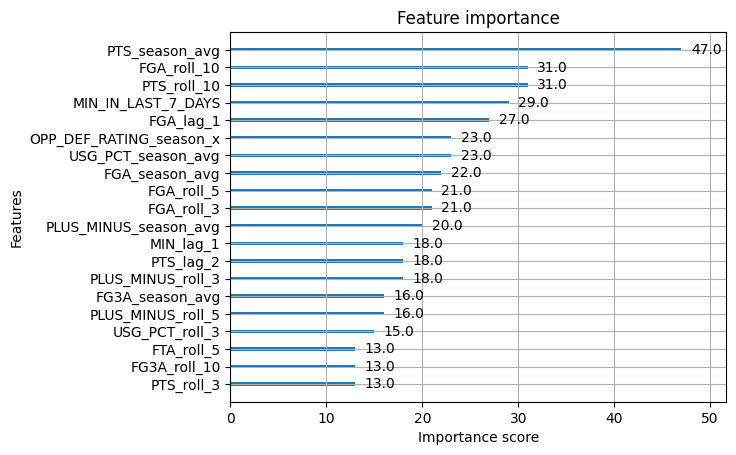

In [17]:
# Evaluate

predictions = model.predict(X_test)
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

# Feature Importance
import matplotlib.pyplot as plt

xgb.plot_importance(model, max_num_features=20)
plt.show()

In [18]:
# Compare with Baseline (Last Game Points)
# A simple baseline is predicting the player will score the same as their last game (or season average).
# Let's use season average as baseline.

baseline_preds = X_test['PTS_season_avg']
baseline_mae = mean_absolute_error(y_test, baseline_preds)

print(f"Baseline MAE (Season Avg): {baseline_mae:.4f}")
print(f"Model MAE: {mae:.4f}")
print(f"Model Improvement: {baseline_mae - mae:.4f}")

Baseline MAE (Season Avg): 5.3118
Model MAE: 4.6792
Model Improvement: 0.6327


## Next Steps
1.  **Hyperparameter Tuning**: Use RandomizedSearchCV to find better parameters.
2.  **More Features**: Advanced stats (USG%, TS%), player fatigue, travel distance.
3.  **Ensemble**: Stack with other models.